### **Install Dependencies**

In [ ]:
!pip install torchmetrics
!pip install albumentations
!pip install gdown

# Install dataset
!gdown 16EuPTzv2sGWlKdoPhqHm3pNN3A5iNiwv
!unzip  -q coco_traffic_images.zip
!rm -r coco_traffic_images.zip

!gdown 16zhU7CvGkXadhxT-Un7jr2xTTLgNNhAh
!unzip -q val_coco_traffic.zip
!rm -r val_coco_traffic.zip

!gdown 1R42e1MTYb3koKVPl6UyulXr9mjtP8h4S
!unzip -q train_coco_traffic.zip
!rm -r train_coco_traffic.zip

# Download pre-trained retinanet
!gdown 1s76JZ6iRKwRMrZ1PzvZTaunjnfLnoJ




Downloading...
From (original): https://drive.google.com/uc?id=1OJxGwX8QuBKcR3CGrWW7VsAM6HH9vsjb
From (redirected): https://drive.google.com/uc?id=1OJxGwX8QuBKcR3CGrWW7VsAM6HH9vsjb&confirm=t&uuid=d3fd1610-12cb-4b16-8452-43018cb28c7a
To: /content/qat_model_epoch_7_ckpt.pt
100% 147M/147M [00:02<00:00, 72.3MB/s]


### **Dataset & DataLoader**

##### ***Define***

In [ ]:
import cv2
import json
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader

CLASSES = ['background','bicycle', 'bus', 'car', 'motorcycle', "person"]
 

class ODCOCOTrafficDataset(Dataset):
  def __init__(self, anno_path, img_dir, transforms):
    self.img_root = img_dir + '/%s.jpg'
    ids, annos = self._load_annos(anno_path)
    self.ids = list(ids)
    self.annos = list(annos)
    self.transforms = transforms

    self.class_to_ind = dict(
          zip(CLASSES, range(len(CLASSES))))

  def _load_annos(self, anno_path):
      with open(anno_path, 'r') as file:
        data = json.load(file)
        return data.keys(), data.values()

  def __len__(self):
      return len(self.ids)


  def __getitem__(self, idx):
    img_path = self.img_root % self.ids[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    anno = self.annos[idx]
    boxes = []
    labels = []

    for i in range(len(anno[0])):
      boxes.append(anno[0][i])
      labels.append(self.class_to_ind[anno[1][i]])

    if self.transforms is not None:
      transformed = self.transforms(image=img, bboxes=boxes, class_labels=labels)
      img = transformed['image']
      boxes = transformed['bboxes']
      boxes = self._bboxes_coco2yolo(boxes)
      labels = transformed['class_labels']

    return torch.tensor(img).permute(2, 0, 1), boxes, labels

  def _bboxes_coco2yolo(self, bboxes):
    bboxes = torch.tensor(bboxes)
    bboxes[:, 2] += bboxes[:, 0]
    bboxes[:, 3] += bboxes[:, 1]
    return bboxes




def detection_collate(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0].float())
        target = {'boxes':[], 'labels':[]}
        for i in range(len(sample[1])):
          target['boxes'].append(sample[1][i])
          target['labels'].append(sample[2][i])
        target['boxes'] = torch.FloatTensor(np.array(target['boxes']))
        target['labels'] = torch.tensor(target['labels'],  dtype=torch.int64)
        targets.append(target)
    return imgs,  targets


##### ***Create***

In [ ]:
import os
import albumentations as A

num_workers = os.cpu_count()

test_transforms = A.Compose([
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1, 1, 1],
    ),
], bbox_params=A.BboxParams(format='coco',label_fields=['class_labels']))

train_transforms = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1, 1, 1],
    ),
], bbox_params=A.BboxParams(format='coco',label_fields=['class_labels']))


train_anno_path = 'train_anno_traffic.json'
train_img_dir = 'coco_traffic_images'
test_anno_path = 'val_anno_traffic.json'
test_img_dir = 'coco_traffic_images'
batch_size = 3
test_batch_size = 16

train_set = ODCOCOTrafficDataset(train_anno_path, train_img_dir,
                                train_transforms)

train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, collate_fn=detection_collate,
                          num_workers=num_workers)


test_set = ODCOCOTrafficDataset(test_anno_path, test_img_dir,
                                test_transforms)

test_loader = DataLoader(test_set, batch_size=test_batch_size,
                          shuffle=False, collate_fn=detection_collate,
                          num_workers=num_workers)


### **Retinanet Model**

##### ***Forward function***

In [ ]:
from torchvision.ops import sigmoid_focal_loss
from torchvision.models.detection._utils import _box_loss


def Retinanet_forward(self, images, targets=None):
  if self.training:
      if targets is None:
          torch._assert(False, "targets should not be none when in training mode")
      else:
          for target in targets:
              boxes = target["boxes"]
              torch._assert(isinstance(boxes, torch.Tensor), "Expected target boxes to be of type Tensor.")
              torch._assert(
                  len(boxes.shape) == 2 and boxes.shape[-1] == 4,
                  "Expected target boxes to be a tensor of shape [N, 4].",
              )

  # get the original image sizes
  original_image_sizes: List[Tuple[int, int]] = []
  for img in images:
      val = img.shape[-2:]
      torch._assert(
          len(val) == 2,
          f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
      )
      original_image_sizes.append((val[0], val[1]))

  # transform the input
  images, targets = self.transform(images, targets)

  # Check for degenerate boxes
  # TODO: Move this to a function
  if targets is not None:
      for target_idx, target in enumerate(targets):
          boxes = target["boxes"]
          degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
          if degenerate_boxes.any():
              # print the first degenerate box
              bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
              degen_bb: List[float] = boxes[bb_idx].tolist()
              torch._assert(
                  False,
                  "All bounding boxes should have positive height and width."
                  f" Found invalid box {degen_bb} for target at index {target_idx}.",
              )

  # get the features from the backbone
  if hasattr(self, 'quant'):
    images.tensors = self.quant(images.tensors)

  features = self.backbone(images.tensors)
  if isinstance(features, torch.Tensor):
      features = OrderedDict([("0", features)])

  # TODO: Do we want a list or a dict?
  features = list(features.values())

  head_outputs = {'cls_logits': self.head.classification_head(features)}

  if hasattr(self, 'dequant'):
    images.tensors = self.dequant(images.tensors)
    for i in range(len(features)):
      features[i] = self.dequant(features[i])

    for key in head_outputs:
      head_outputs[key] = self.dequant(head_outputs[key])

  head_outputs['bbox_regression'] = self.head.regression_head(features)

  # create the set of anchors
  anchors = self.anchor_generator(images, features)

  losses = {}
  detections: List[Dict[str, Tensor]] = []
  if self.training:
      if targets is None:
          torch._assert(False, "targets should not be none when in training mode")
      else:
          # compute the losses
          losses = self.compute_loss(targets, head_outputs, anchors)
  else:
      # recover level sizes
      num_anchors_per_level = [x.size(2) * x.size(3) for x in features]
      HW = 0
      for v in num_anchors_per_level:
          HW += v
      HWA = head_outputs["cls_logits"].size(1)
      A = HWA // HW
      num_anchors_per_level = [hw * A for hw in num_anchors_per_level]

      # split outputs per level
      split_head_outputs: Dict[str, List[Tensor]] = {}
      for k in head_outputs:
          split_head_outputs[k] = list(head_outputs[k].split(num_anchors_per_level, dim=1))
      split_anchors = [list(a.split(num_anchors_per_level)) for a in anchors]

      # compute the detections
      detections = self.postprocess_detections(split_head_outputs, split_anchors, images.image_sizes)
      detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

  return self.eager_outputs(losses, detections)




##### ***Create***

In [ ]:
import os
import math
import torch
import torchvision
import torch.nn as nn
import albumentations as A

from functools import partial
from torchvision.models.quantization.resnet import resnet50
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor


ckpt_path = '/content/retinanet_epoch_2_ckpt'

# Create quantized resnet backbone
quantized_backbone = resnet50(quantize=False)
quantized_backbone = _resnet_fpn_extractor(
    quantized_backbone, 3, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(2048, 256)
)
quantized_backbone.eval()


# Create retinanet model
model_float32 = retinanet_resnet50_fpn_v2()
model_float32.backbone = quantized_backbone


# Custom classifer layer
model_float32.num_classes = 6
model_float32.head.classification_head.num_classes = 6
cls_logits = nn.Conv2d(256, 6*9, kernel_size=3, stride=1, padding=1)
model_float32.head.classification_head.cls_logits = cls_logits


# Load weights if file exists
if os.path.exists(ckpt_path):
  print(f"Load model from: {ckpt_path}")
  checkpoint = torch.load(ckpt_path, map_location='cpu')
  model_float32.load_state_dict(checkpoint['model_state_dict'])


# Overide forward function
model_float32.forward = partial(Retinanet_forward, model_float32)


### **Quantized Model**

##### ***Utility Functions***

In [ ]:
import time

def train(model, optimizer, data_loader, device, epoch, num_epochs, print_step=50, limit=None):
  print(f'train [{epoch+1}/{num_epochs}]'.center(50, '='))
  model.train()
  total_steps = limit if limit else len(data_loader)
  total_time = 0

  for step, (images, targets) in enumerate(data_loader):
    st = time.time()

    images = [image.to(device) for image in images]
    for idx in range(len(targets)):
      targets[idx]['boxes'] =  targets[idx]['boxes'].to(device)
      targets[idx]['labels'] = targets[idx]['labels'].to(device)

    _losses = model(images, targets)

    cls_loss = _losses['classification']
    bbox_loss = _losses['bbox_regression']
    losses = cls_loss + bbox_loss

    losses.backward()
    optimizer.step()
    optimizer.zero_grad()

    time_step = time.time() - st
    total_time += time_step
    avg_time_step = total_time/(step+1)
    remaining_time = avg_time_step * (total_steps-step-1)

    if (step+1) % print_step == 0:
      print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{step+1}/{total_steps}], losses: {losses:.4f}, cls_loss: {cls_loss:.4f}, bbox_loss: {bbox_loss:.4f}, time_step: {time_step:.2f}, avg_time_step: {avg_time_step:.2f} | [{total_time:.2f} / {remaining_time:.2f}]')

    if step+1 == limit:
      break
  torch.cuda.empty_cache()



def prepare_map_input(model, data_loader, device,  epoch, out_dir='./', model_name='', print_step=10):
    print('prepare_map_input'.center(50, '-'))
    model.eval()
    model = model.to(device)
    map_input = []
    total_time = 0
    total_steps = len(data_loader)

    with torch.no_grad():
        data_iter = iter(data_loader)
        for step in range(total_steps):
            st = time.time()
            images, targets = next(data_iter)
            images = [image.to(device) for image in images]
            preds = model(images)
            for i in range(len(preds)):
                preds[i]['boxes'] = preds[i]['boxes'].cpu()
                preds[i]['labels'] = preds[i]['labels'].cpu()
                preds[i]['scores'] = preds[i]['scores'].cpu()

            map_input.append([preds, targets])
            torch.cuda.empty_cache()
            time_step = time.time() - st
            total_time += time_step
            avg_time_step = total_time/(step+1)
            remaining_time = avg_time_step * (total_steps-step-1)

            if (step + 1)%print_step == 0:
                print(f"  Step: [{step+1}/{total_steps}], time_step: {time_step:.2f}s, avg_time_step: {avg_time_step:.2f}s | [{total_time:.2f}s / {remaining_time:.2f}s]")
    save_path_format = f'%s/map_input_%s_epoch_%s.pt'
    save_path = save_path_format % (out_dir, model_name, epoch)
    torch.save(map_input, save_path)
    torch.cuda.empty_cache()

##### ***Customized functions to quantize***

In [ ]:
import torch.nn.functional as F

from collections import OrderedDict
from torchvision.models.quantization.utils import _fuse_modules
from torchvision.models.quantization.resnet import (
    QuantizableBottleneck,
    QuantizableBasicBlock
)

def Resnet_fuse_model(self, is_qat=None) -> None:
    _fuse_modules(self, ["conv1", "bn1", "relu"], is_qat, inplace=True)
    for m in self.modules():
        if type(m) is QuantizableBottleneck or type(m) is QuantizableBasicBlock:
            m.fuse_model(is_qat)


def Fpn_forward(self, x):
    names = list(x.keys())
    x = list(x.values())

    last_inner = self.get_result_from_inner_blocks(x[-1], -1)
    results = []
    results.append(self.get_result_from_layer_blocks(last_inner, -1))

    for idx in range(len(x) - 2, -1, -1):
        inner_lateral = self.get_result_from_inner_blocks(x[idx], idx)
        feat_shape = inner_lateral.shape[-2:]
        inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
        last_inner = self.f_add.add(inner_lateral, inner_top_down)
        results.insert(0, self.get_result_from_layer_blocks(last_inner, idx))

    if self.extra_blocks is not None:
        results, names = self.extra_blocks(results, x, names)

    out = OrderedDict([(k, v) for k, v in zip(names, results)])
    return out



def RetinaNetClassificationHead_forward(self, x):
    # type: (List[Tensor]) -> Tensor
    all_cls_logits = []

    for features in x:
        cls_logits = self.conv(features)
        cls_logits = self.cls_logits(cls_logits)

        # Permute classification output from (N, A * K, H, W) to (N, HWA, K).
        N, _, H, W = cls_logits.shape
        cls_logits = cls_logits.view(N, -1, self.num_classes, H, W)
        cls_logits = cls_logits.permute(0, 3, 4, 1, 2)
        cls_logits = cls_logits.reshape(N, -1, self.num_classes)  # Size=(N, HWA, 4)

        all_cls_logits.append(cls_logits)

    return self.f_cat.cat(all_cls_logits, dim=1)


##### ***Create model to quantize***

In [ ]:
import copy
from functools import partial

model_to_quantize = copy.deepcopy(model_float32)

# Fuse backbone model
model_to_quantize.backbone.body.eval()
Resnet_fuse_model(model_to_quantize.backbone.body, is_qat=True)

# Create quant and dequant
model_to_quantize.quant = torch.ao.quantization.QuantStub()
model_to_quantize.dequant = torch.ao.quantization.DeQuantStub()

# Overide forward functions of retinanet, backbone.fpn, head.classification_head
model_to_quantize.forward = partial(Retinanet_forward, model_to_quantize)
model_to_quantize.backbone.fpn.f_add = torch.ao.nn.quantized.FloatFunctional()
model_to_quantize.backbone.fpn.forward = partial(Fpn_forward, model_to_quantize.backbone.fpn)
model_to_quantize.head.classification_head.f_cat = torch.ao.nn.quantized.FloatFunctional()
model_to_quantize.head.classification_head.forward =  partial(RetinaNetClassificationHead_forward, model_to_quantize.head.classification_head)


# Config
model_to_quantize.quant.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_to_quantize.dequant.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_to_quantize.backbone.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_to_quantize.head.classification_head.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model_to_quantize.head.regression_head.qconfig = None

# Prepare
model_to_quantize.train()
model_to_quantize = torch.ao.quantization.prepare_qat(model_to_quantize)


# Load weight if exists
prepare_qat_model_weights_path = '/content/qat_model_epoch_7_ckpt.pt'
if os.path.exists(prepare_qat_model_weights_path):
  print(f"Load weights into model_to_quantize from {prepare_qat_model_weights_path}")
  prepare_qat_model_weights = torch.load(prepare_qat_model_weights_path)
  model_to_quantize.load_state_dict(prepare_qat_model_weights)



/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Load weights into model_to_quantize from /content/qat_model_epoch_7_ckpt.pt


##### ***Calibratate***

In [ ]:
import time

num_epochs = 8
lr = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model_to_quantize.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
model_to_quantize = model_to_quantize.to(device)
model_to_quantize.train()

total_time = time.time()
for epoch in range(num_epochs):
  train(model_to_quantize, optimizer, train_loader, device, epoch, num_epochs, limit=100)
  prepare_map_input(model_to_quantize, test_loader, device, epoch+1,  './',  'quantized_model')
  torch.save(model_to_quantize.state_dict(), f'prepare_qat_retinanet_epoch_{epoch+1}_ckpt.pt')
  if epoch > 3:
      # Freeze quantizer parame  ters
      model_to_quantize.apply(torch.ao.quantization.disable_observer)
  if epoch > 2:
      # Freeze batch norm mean and variance estimates
      model_to_quantize.apply(torch.nn.intrinsic.qat.freeze_bn_stats)
total_time -= time.time()

print(f"Total time: {-(total_time/60):.2f} minutes")



##### ***Convert to model int8***

In [ ]:
model_to_quantize = model_to_quantize.cpu()
model_to_quantize.eval()
model_int8 = torch.ao.quantization.convert(model_to_quantize)

model_int8_path = 'retinanet_int8_weights.pt'
torch.save(model_int8.state_dict(), model_int8_path)

### **Evaluate**

##### ***Evaluate functions***

In [ ]:
import time
import torch


def evaluate_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return size


def evaluate_latency(model, batchs):
  st = time.time()
  for batch in batchs:
    model(batch)
  end = time.time()
  avg_time_step = (end-st)/len(batchs)
  return avg_time_step



def evaluate_map(map_input):
  metric = MeanAveragePrecision(iou_type="bbox")
  for preds, targets in map_input:
    metric.update(preds, targets)
  out = metric.compute()
  out.pop('classes')
  return out

##### ***Run & Display***

In [ ]:
import pandas as pd

model_float32_dict = dict()
model_float32_dict['size'] = evaluate_size(model_float32)
model_float32_dict['latency'] = evaluate_latency(model_float32, test_loader, limit=100)
float32_map_input = prepare_map_input(model_float32, test_loader, device,  epoch, out_dir='./', model_name='', print_step=10)
model_float32_dict.update(evaluate_map(model_float32))

model_int8_dict = dict()
model_int8_dict['size'] = evaluate_size(model_int8)
model_int8_dict['latency'] = evaluate_latency(model_int8, test_loader, limit=100)
model_int8_dict.update(evaluate_map(model_int8, test_loader))
int8_map_input = prepare_map_input(model_int8_dict, test_loader, device,  epoch, out_dir='./', model_name='', print_step=10)
model_int8_dict.update(evaluate_map(int8_map_input))



# Create a pandas DataFrame from the two dictionaries
df = pd.DataFrame([model_float32_dict, model_int8_dict], index=['Float32', 'Int8'])

print(df)


================prepare_map_input=================


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Step: [30/263], time_step: 0.35s, avg_time_step: 0.46s | [13.66s / 106.13s]
Step: [60/263], time_step: 0.45s, avg_time_step: 0.44s | [26.23s / 88.74s]
Step: [90/263], time_step: 0.36s, avg_time_step: 0.43s | [38.71s / 74.41s]
Step: [120/263], time_step: 0.40s, avg_time_step: 0.43s | [51.77s / 61.69s]
Step: [150/263], time_step: 0.51s, avg_time_step: 0.44s | [65.67s / 49.47s]
Step: [180/263], time_step: 0.38s, avg_time_step: 0.44s | [78.53s / 36.21s]
Step: [210/263], time_step: 0.38s, avg_time_step: 0.43s | [91.21s / 23.02s]
Step: [240/263], time_step: 0.56s, avg_time_step: 0.43s | [104.31s / 10.00s]


In [ ]:
import torch
from torchmetrics.detection import MeanAveragePrecision

prepare_map_input(model_to_quantize, test_loader, 'cuda', 1,  './',  'quantized_model')

model_float32_map = torch.load('/content/map_input_quantized_model_epoch_1.pt')

metric = MeanAveragePrecision(iou_type="bbox")
for preds, targets in model_float32_map:
  metric.update(preds, targets)
out = metric.compute()

# print(out)
out.pop('classes')
for key in out:
  print(f'{key}: {out[key].item()}')


----------------prepare_map_input-----------------
  Step: [10/50], time_step: 3.14s, avg_time_step: 3.42s | [34.22s / 136.89s]
  Step: [20/50], time_step: 3.34s, avg_time_step: 3.37s | [67.41s / 101.11s]
  Step: [30/50], time_step: 3.46s, avg_time_step: 3.39s | [101.62s / 67.75s]
  Step: [40/50], time_step: 3.28s, avg_time_step: 3.36s | [134.52s / 33.63s]
  Step: [50/50], time_step: 0.83s, avg_time_step: 3.26s | [162.99s / 0.00s]


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


map: 0.2954949736595154
map_50: 0.5345907807350159
map_75: 0.28820645809173584
map_small: 0.1158970296382904
map_medium: 0.28817641735076904
map_large: 0.42701685428619385
mar_1: 0.21062815189361572
mar_10: 0.4309238791465759
mar_100: 0.49486640095710754
mar_small: 0.2739505171775818
mar_medium: 0.4815264642238617
mar_large: 0.6365024447441101
map_per_class: -1.0
mar_100_per_class: -1.0


### **Demo**

##### ***Download images***

In [ ]:

# !wget -O people_horse.jpg https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/14/2023/01/TA7899-2-920x518.jpg
# !wget -O people.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/2011_MuchMusic_Video_Awards_-_Foster_the_People.jpg/800px-2011_MuchMusic_Video_Awards_-_Foster_the_People.jpg
!wget -O cars.jpg https://www.usatoday.com/gcdn/media/USATODAY/GenericImages/2013/04/23/traffic-pic-16_9.jpg?width=660&height=373&fit=crop&format=pjpg&auto=webp

--2024-07-12 02:56:05--  https://www.usatoday.com/gcdn/media/USATODAY/GenericImages/2013/04/23/traffic-pic-16_9.jpg?width=660
Resolving www.usatoday.com (www.usatoday.com)... 151.101.2.62, 151.101.66.62, 151.101.130.62, ...
Connecting to www.usatoday.com (www.usatoday.com)|151.101.2.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46622 (46K) [image/jpeg]
Saving to: ‘cars.jpg’

cars.jpg            100%[===================>]  45.53K  --.-KB/s    in 0.007s  

2024-07-12 02:56:05 (6.10 MB/s) - ‘cars.jpg’ saved [46622/46622]



##### ***Utility Functions***

In [ ]:
import cv2
import torchvision.transforms as transforms

from PIL import Image


COLORMAP = [(0,   0,   0),
            (0,   128, 0),
            (0,   0,   255),
            (255, 255, 0),
            (255, 0,   0),
            (160, 32,  240)]
CLASSES = ['background','bicycle', 'bus', 'car', 'motorcycle', "person"]


def draw_rectangle(image, x_min, y_min, x_max, y_max, object_name="None"):
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    cv2.putText(image, object_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


def read_rgb_img(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def predict(model, img_path):
  model.eval()
  with torch.no_grad():
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    img = read_rgb_img(img_path)
    img = torch.tensor(img).permute(2, 0, 1) / 255
    detections = model([img])
    score_indexes  = torch.argsort(detections[0]['scores'])

    output = read_rgb_img(img_path)
    for idx in score_indexes:
      score = detections[0]['scores'][idx]
      box = detections[0]['boxes'][idx]
      label = detections[0]['labels'][idx]
      label = CLASSES[label] + f': {score:.2f}'
      if score>0.5:
        draw_rectangle(output, box[0], box[1], box[2], box[3], label)

    output = to_pil(to_tensor(output))
    return output



##### ***Run***

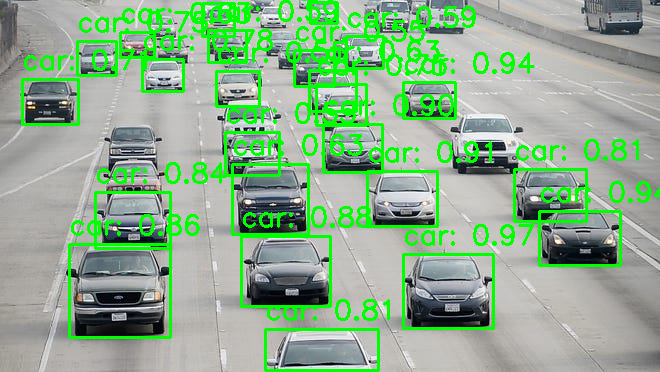

In [ ]:
img_path ='cars.jpg'

img = predict(model_int8, img_path)
img